In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision.models import inception_v3
import torchvision.transforms as transforms
import numpy as np
from scipy.linalg import sqrtm

In [13]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64
dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
subset_indices = torch.randint(high=len(dataset), size=(10000,), dtype=torch.int64)
subset = torch.utils.data.Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [14]:
#Generator class
class Generator(nn.Module):
    def __init__(self, noise_dim=124):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim

        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 2*2*448),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2*2*448)
        )

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(448, 256, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256)
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128)
        )
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(inplace=True)
        )
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2),
            nn.Tanh()
        )

    def forward(self, noise):
        x = self.fc(noise)
        x = x.view(-1, 448, 2, 2)

        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.final_layer(x)
        return x

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 256*4*4)
        x = self.fc(x)
        output = torch.sigmoid(self.output_layer(x))
        return output

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

noise_dim = 124
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
generator.train()
discriminator.train()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

  1%|          | 1/156 [00:02<06:55,  2.68s/it]

[Epoch 0/50] [Batch 0/156] [D loss: -0.006836116313934326] [G loss: -0.4883831739425659]


 65%|██████▍   | 101/156 [03:43<01:49,  2.00s/it]

[Epoch 0/50] [Batch 100/156] [D loss: -0.37700170278549194] [G loss: -0.24749524891376495]


  1%|          | 1/156 [00:02<06:13,  2.41s/it]

[Epoch 1/50] [Batch 0/156] [D loss: -0.34969562292099] [G loss: -0.21322683990001678]


 65%|██████▍   | 101/156 [03:33<01:57,  2.14s/it]

[Epoch 1/50] [Batch 100/156] [D loss: -0.2989703416824341] [G loss: -0.1384653002023697]


  1%|          | 1/156 [00:02<06:01,  2.33s/it]

[Epoch 2/50] [Batch 0/156] [D loss: -0.5824984908103943] [G loss: -0.10877219587564468]


 65%|██████▍   | 101/156 [03:31<01:59,  2.17s/it]

[Epoch 2/50] [Batch 100/156] [D loss: -0.646098792552948] [G loss: -0.07940740883350372]


  1%|          | 1/156 [00:02<06:47,  2.63s/it]

[Epoch 3/50] [Batch 0/156] [D loss: -0.6761302947998047] [G loss: -0.07011721283197403]


 65%|██████▍   | 101/156 [03:29<01:51,  2.03s/it]

[Epoch 3/50] [Batch 100/156] [D loss: -0.6529159545898438] [G loss: -0.05317981541156769]


  1%|          | 1/156 [00:02<07:03,  2.73s/it]

[Epoch 4/50] [Batch 0/156] [D loss: -0.6611238121986389] [G loss: -0.05385691672563553]


 65%|██████▍   | 101/156 [03:31<01:52,  2.05s/it]

[Epoch 4/50] [Batch 100/156] [D loss: -0.6444826126098633] [G loss: -0.058874621987342834]


  1%|          | 1/156 [00:02<05:57,  2.31s/it]

[Epoch 5/50] [Batch 0/156] [D loss: -0.7180420160293579] [G loss: -0.0564638115465641]


 65%|██████▍   | 101/156 [03:29<01:47,  1.96s/it]

[Epoch 5/50] [Batch 100/156] [D loss: -0.7729722261428833] [G loss: -0.04358043521642685]


  1%|          | 1/156 [00:02<07:30,  2.91s/it]

[Epoch 6/50] [Batch 0/156] [D loss: -0.7159447073936462] [G loss: -0.027453530579805374]


 65%|██████▍   | 101/156 [03:29<01:54,  2.08s/it]

[Epoch 6/50] [Batch 100/156] [D loss: -0.6242935061454773] [G loss: -0.024201445281505585]


  1%|          | 1/156 [00:02<06:20,  2.45s/it]

[Epoch 7/50] [Batch 0/156] [D loss: -0.6077138185501099] [G loss: -0.022692548111081123]


 65%|██████▍   | 101/156 [03:30<02:03,  2.24s/it]

[Epoch 7/50] [Batch 100/156] [D loss: -0.7126547694206238] [G loss: -0.024835335090756416]


  1%|          | 1/156 [00:02<06:07,  2.37s/it]

[Epoch 8/50] [Batch 0/156] [D loss: -0.8363394737243652] [G loss: -0.020941011607646942]


 65%|██████▍   | 101/156 [03:32<01:57,  2.13s/it]

[Epoch 8/50] [Batch 100/156] [D loss: -0.7172392010688782] [G loss: -0.019635621458292007]


  1%|          | 1/156 [00:02<06:16,  2.43s/it]

[Epoch 9/50] [Batch 0/156] [D loss: -0.7293902635574341] [G loss: -0.016499262303113937]


 65%|██████▍   | 101/156 [03:36<01:54,  2.08s/it]

[Epoch 9/50] [Batch 100/156] [D loss: -0.7274969816207886] [G loss: -0.017549196258187294]


  1%|          | 1/156 [00:02<06:41,  2.59s/it]

[Epoch 10/50] [Batch 0/156] [D loss: -0.6005924344062805] [G loss: -0.016086677089333534]


 65%|██████▍   | 101/156 [03:33<01:56,  2.12s/it]

[Epoch 10/50] [Batch 100/156] [D loss: -0.6989684700965881] [G loss: -0.010532060638070107]


  1%|          | 1/156 [00:02<05:59,  2.32s/it]

[Epoch 11/50] [Batch 0/156] [D loss: -0.7735552191734314] [G loss: -0.013354391790926456]


 65%|██████▍   | 101/156 [03:34<01:54,  2.09s/it]

[Epoch 11/50] [Batch 100/156] [D loss: -0.7949177622795105] [G loss: -0.0100696487352252]


  1%|          | 1/156 [00:02<06:09,  2.38s/it]

[Epoch 12/50] [Batch 0/156] [D loss: -0.733589768409729] [G loss: -0.01119283027946949]


 65%|██████▍   | 101/156 [03:31<01:57,  2.13s/it]

[Epoch 12/50] [Batch 100/156] [D loss: -0.7929725050926208] [G loss: -0.009205427020788193]


  1%|          | 1/156 [00:02<06:30,  2.52s/it]

[Epoch 13/50] [Batch 0/156] [D loss: -0.650668203830719] [G loss: -0.008154435083270073]


 65%|██████▍   | 101/156 [03:31<01:54,  2.07s/it]

[Epoch 13/50] [Batch 100/156] [D loss: -0.8690387606620789] [G loss: -0.010526761412620544]


  1%|          | 1/156 [00:02<07:44,  2.99s/it]

[Epoch 14/50] [Batch 0/156] [D loss: -0.8014280200004578] [G loss: -0.009274388663470745]


 65%|██████▍   | 101/156 [03:33<01:53,  2.06s/it]

[Epoch 14/50] [Batch 100/156] [D loss: -0.8579903841018677] [G loss: -0.007630454376339912]


  1%|          | 1/156 [00:03<08:19,  3.22s/it]

[Epoch 15/50] [Batch 0/156] [D loss: -0.8536167740821838] [G loss: -0.011789723299443722]


 65%|██████▍   | 101/156 [03:34<01:46,  1.93s/it]

[Epoch 15/50] [Batch 100/156] [D loss: -0.739535391330719] [G loss: -0.00810396857559681]


  1%|          | 1/156 [00:03<07:48,  3.02s/it]

[Epoch 16/50] [Batch 0/156] [D loss: -0.9161925315856934] [G loss: -0.01069269422441721]


 65%|██████▍   | 101/156 [03:33<01:48,  1.97s/it]

[Epoch 16/50] [Batch 100/156] [D loss: -0.8485990762710571] [G loss: -0.006442974787205458]


  1%|          | 1/156 [00:03<07:49,  3.03s/it]

[Epoch 17/50] [Batch 0/156] [D loss: -0.8557888865470886] [G loss: -0.007746165152639151]


 65%|██████▍   | 101/156 [03:31<01:55,  2.10s/it]

[Epoch 17/50] [Batch 100/156] [D loss: -0.8619129061698914] [G loss: -0.00736426142975688]


  1%|          | 1/156 [00:02<06:11,  2.40s/it]

[Epoch 18/50] [Batch 0/156] [D loss: -0.7862638831138611] [G loss: -0.008545157499611378]


 65%|██████▍   | 101/156 [03:31<01:58,  2.16s/it]

[Epoch 18/50] [Batch 100/156] [D loss: -0.8572267889976501] [G loss: -0.007012790068984032]


  1%|          | 1/156 [00:03<08:31,  3.30s/it]

[Epoch 19/50] [Batch 0/156] [D loss: -0.8625653386116028] [G loss: -0.006036332342773676]


 65%|██████▍   | 101/156 [03:32<02:01,  2.21s/it]

[Epoch 19/50] [Batch 100/156] [D loss: -0.6175760626792908] [G loss: -0.005182335153222084]


  1%|          | 1/156 [00:02<06:16,  2.43s/it]

[Epoch 20/50] [Batch 0/156] [D loss: -0.860426664352417] [G loss: -0.007143283728510141]


 65%|██████▍   | 101/156 [03:34<02:02,  2.23s/it]

[Epoch 20/50] [Batch 100/156] [D loss: -0.7469677925109863] [G loss: -0.00479290634393692]


  1%|          | 1/156 [00:02<06:11,  2.40s/it]

[Epoch 21/50] [Batch 0/156] [D loss: -0.7164806723594666] [G loss: -0.005386657081544399]


 65%|██████▍   | 101/156 [03:32<02:01,  2.20s/it]

[Epoch 21/50] [Batch 100/156] [D loss: -0.7961359620094299] [G loss: -0.004983410704880953]


  1%|          | 1/156 [00:02<06:04,  2.35s/it]

[Epoch 22/50] [Batch 0/156] [D loss: -0.7431432008743286] [G loss: -0.003469207091256976]


 65%|██████▍   | 101/156 [03:31<01:49,  1.99s/it]

[Epoch 22/50] [Batch 100/156] [D loss: -0.7885276079177856] [G loss: -0.011207278817892075]


  1%|          | 1/156 [00:02<06:21,  2.46s/it]

[Epoch 23/50] [Batch 0/156] [D loss: -0.703005313873291] [G loss: -0.0066590639762580395]


 65%|██████▍   | 101/156 [03:30<01:49,  1.99s/it]

[Epoch 23/50] [Batch 100/156] [D loss: -0.8517574071884155] [G loss: -0.006703904829919338]


  1%|          | 1/156 [00:03<08:03,  3.12s/it]

[Epoch 24/50] [Batch 0/156] [D loss: -0.8600905537605286] [G loss: -0.0029035471379756927]


 65%|██████▍   | 101/156 [03:34<01:51,  2.02s/it]

[Epoch 24/50] [Batch 100/156] [D loss: -0.7904847860336304] [G loss: -0.00907721184194088]


  1%|          | 1/156 [00:02<06:21,  2.46s/it]

[Epoch 25/50] [Batch 0/156] [D loss: -0.924005389213562] [G loss: -0.005972343496978283]


 65%|██████▍   | 101/156 [03:36<01:50,  2.01s/it]

[Epoch 25/50] [Batch 100/156] [D loss: -0.8580417633056641] [G loss: -0.006970216985791922]


  1%|          | 1/156 [00:03<08:42,  3.37s/it]

[Epoch 26/50] [Batch 0/156] [D loss: -0.85457843542099] [G loss: -0.0027407680172473192]


 65%|██████▍   | 101/156 [03:36<01:48,  1.97s/it]

[Epoch 26/50] [Batch 100/156] [D loss: -0.8627859354019165] [G loss: -0.00785027351230383]


  1%|          | 1/156 [00:02<06:04,  2.35s/it]

[Epoch 27/50] [Batch 0/156] [D loss: -0.8057652115821838] [G loss: -0.0049939705058932304]


 65%|██████▍   | 101/156 [03:35<02:08,  2.34s/it]

[Epoch 27/50] [Batch 100/156] [D loss: -0.7852398157119751] [G loss: -0.007006396073848009]


  1%|          | 1/156 [00:02<06:03,  2.34s/it]

[Epoch 28/50] [Batch 0/156] [D loss: -0.8603610992431641] [G loss: -0.00755867175757885]


 65%|██████▍   | 101/156 [03:34<02:02,  2.22s/it]

[Epoch 28/50] [Batch 100/156] [D loss: -0.5764707326889038] [G loss: -0.0056417761370539665]


  1%|          | 1/156 [00:02<06:24,  2.48s/it]

[Epoch 29/50] [Batch 0/156] [D loss: -0.8659247159957886] [G loss: -0.005471172742545605]


 65%|██████▍   | 101/156 [03:35<01:59,  2.17s/it]

[Epoch 29/50] [Batch 100/156] [D loss: -0.8101564645767212] [G loss: -0.006262542679905891]


  1%|          | 1/156 [00:02<06:20,  2.45s/it]

[Epoch 30/50] [Batch 0/156] [D loss: -0.8063835501670837] [G loss: -0.004824468865990639]


 65%|██████▍   | 101/156 [03:36<01:59,  2.18s/it]

[Epoch 30/50] [Batch 100/156] [D loss: -0.8676156997680664] [G loss: -0.004440573509782553]


  1%|          | 1/156 [00:02<06:09,  2.39s/it]

[Epoch 31/50] [Batch 0/156] [D loss: -0.8050327301025391] [G loss: -0.004674294963479042]


 65%|██████▍   | 101/156 [03:36<01:57,  2.14s/it]

[Epoch 31/50] [Batch 100/156] [D loss: -0.825178325176239] [G loss: -0.06875106692314148]


  1%|          | 1/156 [00:03<08:16,  3.20s/it]

[Epoch 32/50] [Batch 0/156] [D loss: -0.9273048043251038] [G loss: -0.002014461439102888]


 65%|██████▍   | 101/156 [03:41<02:06,  2.29s/it]

[Epoch 32/50] [Batch 100/156] [D loss: -0.8034805059432983] [G loss: -0.0033949152566492558]


  1%|          | 1/156 [00:02<06:13,  2.41s/it]

[Epoch 33/50] [Batch 0/156] [D loss: -0.8042542338371277] [G loss: -0.00309731881134212]


 65%|██████▍   | 101/156 [03:34<02:09,  2.35s/it]

[Epoch 33/50] [Batch 100/156] [D loss: -0.9263287782669067] [G loss: -0.005214731674641371]


  1%|          | 1/156 [00:02<06:26,  2.49s/it]

[Epoch 34/50] [Batch 0/156] [D loss: -0.7448853850364685] [G loss: -0.003410023869946599]


 65%|██████▍   | 101/156 [03:39<01:56,  2.13s/it]

[Epoch 34/50] [Batch 100/156] [D loss: -0.8051838278770447] [G loss: -0.004483009688556194]


  1%|          | 1/156 [00:03<08:32,  3.31s/it]

[Epoch 35/50] [Batch 0/156] [D loss: -0.7809963226318359] [G loss: -0.006322672590613365]


 65%|██████▍   | 101/156 [03:40<02:06,  2.29s/it]

[Epoch 35/50] [Batch 100/156] [D loss: -0.853691816329956] [G loss: -0.009176556020975113]


  1%|          | 1/156 [00:02<06:12,  2.41s/it]

[Epoch 36/50] [Batch 0/156] [D loss: -0.6815224289894104] [G loss: -0.006002394948154688]


 65%|██████▍   | 101/156 [03:37<01:53,  2.07s/it]

[Epoch 36/50] [Batch 100/156] [D loss: -0.804133951663971] [G loss: -0.005831228103488684]


  1%|          | 1/156 [00:03<08:42,  3.37s/it]

[Epoch 37/50] [Batch 0/156] [D loss: -0.9239652156829834] [G loss: -0.004934949334710836]


 65%|██████▍   | 101/156 [03:35<01:48,  1.98s/it]

[Epoch 37/50] [Batch 100/156] [D loss: -0.8609342575073242] [G loss: -0.005996454507112503]


  1%|          | 1/156 [00:02<06:18,  2.44s/it]

[Epoch 38/50] [Batch 0/156] [D loss: -0.8635765910148621] [G loss: -0.004871309734880924]


 65%|██████▍   | 101/156 [03:38<02:06,  2.31s/it]

[Epoch 38/50] [Batch 100/156] [D loss: -0.8857853412628174] [G loss: -0.0019653476774692535]


  1%|          | 1/156 [00:02<06:22,  2.47s/it]

[Epoch 39/50] [Batch 0/156] [D loss: -0.8711658120155334] [G loss: -0.004028568044304848]


 65%|██████▍   | 101/156 [03:37<01:51,  2.02s/it]

[Epoch 39/50] [Batch 100/156] [D loss: -0.8034382462501526] [G loss: -0.004376070108264685]


  1%|          | 1/156 [00:03<08:14,  3.19s/it]

[Epoch 40/50] [Batch 0/156] [D loss: -0.8746048212051392] [G loss: -0.0049934908747673035]


 65%|██████▍   | 101/156 [03:39<02:03,  2.25s/it]

[Epoch 40/50] [Batch 100/156] [D loss: -0.7392004132270813] [G loss: -0.006193116772919893]


  1%|          | 1/156 [00:02<06:15,  2.42s/it]

[Epoch 41/50] [Batch 0/156] [D loss: -0.8353850245475769] [G loss: -0.006507787853479385]


 65%|██████▍   | 101/156 [03:36<02:02,  2.23s/it]

[Epoch 41/50] [Batch 100/156] [D loss: -0.927269697189331] [G loss: -0.0037260961253196]


  1%|          | 1/156 [00:03<08:24,  3.25s/it]

[Epoch 42/50] [Batch 0/156] [D loss: -0.9215235114097595] [G loss: -0.004351325333118439]


 65%|██████▍   | 101/156 [03:36<01:49,  1.99s/it]

[Epoch 42/50] [Batch 100/156] [D loss: -0.8537431955337524] [G loss: -0.011970408260822296]


  1%|          | 1/156 [00:03<09:43,  3.76s/it]

[Epoch 43/50] [Batch 0/156] [D loss: -0.9214450716972351] [G loss: -0.005926055833697319]


 65%|██████▍   | 101/156 [03:36<01:50,  2.01s/it]

[Epoch 43/50] [Batch 100/156] [D loss: -0.865303635597229] [G loss: -0.004769018851220608]


  1%|          | 1/156 [00:02<06:35,  2.55s/it]

[Epoch 44/50] [Batch 0/156] [D loss: -0.6809375882148743] [G loss: -0.003660486778244376]


 65%|██████▍   | 101/156 [03:34<01:54,  2.09s/it]

[Epoch 44/50] [Batch 100/156] [D loss: -0.8389265537261963] [G loss: -0.004471804480999708]


  1%|          | 1/156 [00:02<06:23,  2.47s/it]

[Epoch 45/50] [Batch 0/156] [D loss: -0.6807333827018738] [G loss: -0.004499303176999092]


 65%|██████▍   | 101/156 [03:40<01:59,  2.17s/it]

[Epoch 45/50] [Batch 100/156] [D loss: -0.9310256838798523] [G loss: -0.002909480594098568]


  1%|          | 1/156 [00:02<06:13,  2.41s/it]

[Epoch 46/50] [Batch 0/156] [D loss: -0.6826879978179932] [G loss: -0.0034058284945786]


 65%|██████▍   | 101/156 [03:38<01:49,  1.99s/it]

[Epoch 46/50] [Batch 100/156] [D loss: -0.8709452748298645] [G loss: -0.0030313278548419476]


  1%|          | 1/156 [00:03<07:50,  3.04s/it]

[Epoch 47/50] [Batch 0/156] [D loss: -0.9277058839797974] [G loss: -0.0034766606986522675]


 65%|██████▍   | 101/156 [03:39<02:03,  2.24s/it]

[Epoch 47/50] [Batch 100/156] [D loss: -0.8075562715530396] [G loss: -0.003693077713251114]


  1%|          | 1/156 [00:02<06:27,  2.50s/it]

[Epoch 48/50] [Batch 0/156] [D loss: -0.8639125823974609] [G loss: -0.003029133891686797]


 65%|██████▍   | 101/156 [03:36<01:55,  2.11s/it]

[Epoch 48/50] [Batch 100/156] [D loss: -0.8695207834243774] [G loss: -0.0032478226348757744]


  1%|          | 1/156 [00:02<07:25,  2.88s/it]

[Epoch 49/50] [Batch 0/156] [D loss: -0.8040723204612732] [G loss: -0.0043706647120416164]


 65%|██████▍   | 101/156 [03:42<02:06,  2.30s/it]

[Epoch 49/50] [Batch 100/156] [D loss: -0.8239325881004333] [G loss: -0.0035959891974925995]


100%|██████████| 156/156 [05:41<00:00,  2.19s/it]


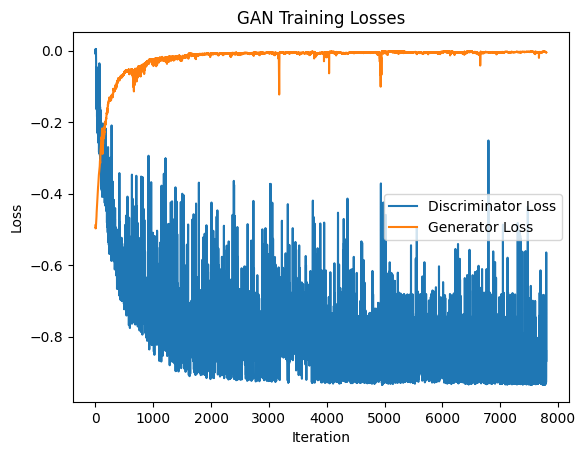

In [15]:
#Define loss function
criterion = nn.BCELoss()

d_losses = []
g_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader)):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, noise_dim, device=device)
        optimizer_D.zero_grad()

        real_output = discriminator(real_images)
        real_loss = -real_output.mean()

        generated_images = generator(noise)
        fake_output = discriminator(generated_images.detach())
        fake_loss = fake_output.mean()

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        generated_images = generator(noise)
        validity = discriminator(generated_images)
        g_loss = -validity.mean()

        g_loss.backward()
        optimizer_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Plot losses
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()

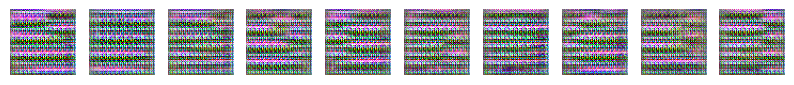

In [16]:
# Visualize the generated images
generator.eval()

num_images_to_generate = 10
noise = torch.randn(num_images_to_generate, noise_dim, device=device)

with torch.no_grad():
    generated_images = generator(noise).cpu()

plt.figure(figsize=(10, 1))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i+1)
    plt.imshow(generated_images[i].permute(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')
plt.show()

  1%|          | 1/156 [00:03<08:39,  3.35s/it]

[Epoch 0/10] [Batch 0/156] [D loss: 0.1918637603521347] [G loss: 0.9694369435310364]


 65%|██████▍   | 101/156 [03:41<01:59,  2.17s/it]

[Epoch 0/10] [Batch 100/156] [D loss: 0.23685185611248016] [G loss: 0.8769499659538269]


  1%|          | 1/156 [00:02<06:07,  2.37s/it]

[Epoch 1/10] [Batch 0/156] [D loss: 0.12804728746414185] [G loss: 0.9812617897987366]


 65%|██████▍   | 101/156 [03:37<01:52,  2.04s/it]

[Epoch 1/10] [Batch 100/156] [D loss: 0.1257123351097107] [G loss: 0.9803009033203125]


  1%|          | 1/156 [00:02<06:01,  2.33s/it]

[Epoch 2/10] [Batch 0/156] [D loss: 0.1882583349943161] [G loss: 0.9763721823692322]


 65%|██████▍   | 101/156 [03:37<02:04,  2.27s/it]

[Epoch 2/10] [Batch 100/156] [D loss: 0.07232788950204849] [G loss: 0.9851542711257935]


  1%|          | 1/156 [00:02<06:09,  2.39s/it]

[Epoch 3/10] [Batch 0/156] [D loss: 0.12843379378318787] [G loss: 0.9769582748413086]


 65%|██████▍   | 101/156 [03:36<01:54,  2.08s/it]

[Epoch 3/10] [Batch 100/156] [D loss: 0.07219763100147247] [G loss: 0.9821654558181763]


  1%|          | 1/156 [00:02<06:02,  2.34s/it]

[Epoch 4/10] [Batch 0/156] [D loss: 0.06567497551441193] [G loss: 0.9824030995368958]


 65%|██████▍   | 101/156 [03:34<01:58,  2.16s/it]

[Epoch 4/10] [Batch 100/156] [D loss: 0.12837761640548706] [G loss: 0.9799325466156006]


  1%|          | 1/156 [00:02<07:40,  2.97s/it]

[Epoch 5/10] [Batch 0/156] [D loss: 0.3446892499923706] [G loss: 0.8662816882133484]


 65%|██████▍   | 101/156 [03:34<01:54,  2.08s/it]

[Epoch 5/10] [Batch 100/156] [D loss: 0.06377696245908737] [G loss: 0.9742928743362427]


  1%|          | 1/156 [00:03<07:53,  3.05s/it]

[Epoch 6/10] [Batch 0/156] [D loss: 0.23647405207157135] [G loss: 0.8806750774383545]


 65%|██████▍   | 101/156 [03:35<01:52,  2.05s/it]

[Epoch 6/10] [Batch 100/156] [D loss: 0.12719984352588654] [G loss: 0.9781949520111084]


  1%|          | 1/156 [00:02<06:38,  2.57s/it]

[Epoch 7/10] [Batch 0/156] [D loss: 0.1297738254070282] [G loss: 0.9618375301361084]


 65%|██████▍   | 101/156 [03:35<02:01,  2.21s/it]

[Epoch 7/10] [Batch 100/156] [D loss: 0.1807728111743927] [G loss: 0.9224673509597778]


  1%|          | 1/156 [00:02<06:16,  2.43s/it]

[Epoch 8/10] [Batch 0/156] [D loss: 0.0669131875038147] [G loss: 0.9786695837974548]


 65%|██████▍   | 101/156 [03:36<02:04,  2.27s/it]

[Epoch 8/10] [Batch 100/156] [D loss: 0.06434603780508041] [G loss: 0.9593417644500732]


  1%|          | 1/156 [00:02<06:00,  2.33s/it]

[Epoch 9/10] [Batch 0/156] [D loss: 0.06674252450466156] [G loss: 0.9508047103881836]


 65%|██████▍   | 101/156 [03:30<01:57,  2.13s/it]

[Epoch 9/10] [Batch 100/156] [D loss: 0.16768300533294678] [G loss: 0.6509415507316589]


100%|██████████| 156/156 [05:25<00:00,  2.09s/it]


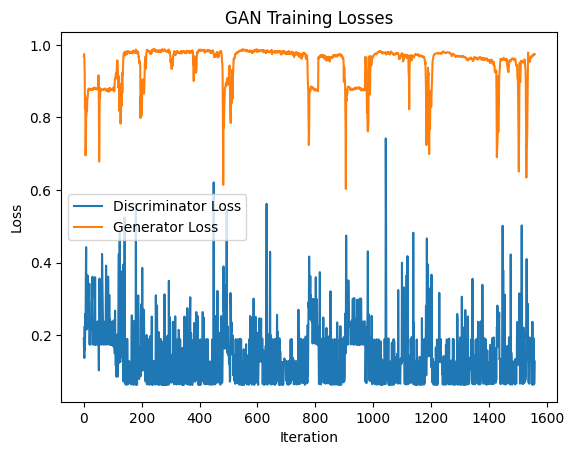

In [19]:
# Define mean squared error (MSE) loss
criterion = nn.MSELoss()
num_epochs = 10

d_losses = []
g_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader)):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, noise_dim, device=device)
        optimizer_D.zero_grad()

        real_output = discriminator(real_images)
        real_loss = torch.mean((real_output - 1) ** 2)

        generated_images = generator(noise)
        fake_output = discriminator(generated_images.detach())
        fake_loss = torch.mean(fake_output ** 2)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        generated_images = generator(noise)
        validity = discriminator(generated_images)
        g_loss = torch.mean((validity - 1) ** 2)

        g_loss.backward()
        optimizer_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Plot losses
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()

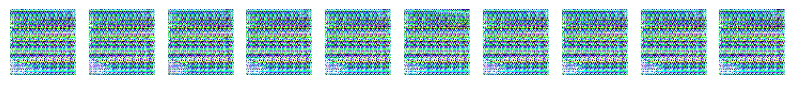

In [20]:
#Generate visualized images
generator.eval()

num_images_to_generate = 10
noise = torch.randn(num_images_to_generate, noise_dim, device=device)

with torch.no_grad():
    generated_images = generator(noise).cpu()

plt.figure(figsize=(10, 1))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i+1)
    plt.imshow(generated_images[i].permute(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')
plt.show()